<a href="https://colab.research.google.com/github/jarussell/OReillyColab/blob/master/O'Reilly_ML_Engineer_Take_Home_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a take-home exam as part of a job search.

Solution by Jacob Russell

Overview:
- Make a copy of this notebook.
- Download the dataset to the notebook (link in Step 2 comments)
- Preprocess and evaluate the dataset
- Build a **ranking** model
- Evaluate your ranking model using a metric of your choice
- Answer discussion questions
- Submit your notebook


## Notes

 

*   Throughout the notebook you should include notes explaining your choices and what you are doing. Your thought process is more important than the actual performance of your model.
*   Create as many cells as you want. The exisiting cells are just provided to provide some initial organization.
* You may use any choice of libraries or frameworks.
* If ranking models are new to you, consider starting here:<br>
  &nbsp;&nbsp;&nbsp;&nbsp;LTR Intro http://times.cs.uiuc.edu/course/598f14/l2r.pdf (overview/introduction to Learning to Rank - 2011)<br>
  &nbsp;&nbsp;&nbsp;&nbsp;TFR https://arxiv.org/abs/1812.00073 (a specific implementation/framework for Learning to Rank models - 2019)

# The Model

### 1) Imports

In [1]:
# Import dependencies here

import pandas as pd
import urllib.request #for downloading zip
import pathlib 
from zipfile import ZipFile
import hashlib #for security/verifying download

import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
import scipy.stats as stats
from sklearn.model_selection import PredefinedSplit

import gc

/home/blueblob/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/blueblob/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/blueblob/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


### 2) Download Dataset
The utility of a notebook that does not automatically acquire the data is not high. I have put a little bit of extra effort into making sure that the notebook should run as long as you:
`pip install -U pandas urllib xgboost sklearn matplotlib scipy`.

I apologize for how slow the notebook is.

In [2]:
# Download the dataset located at https://storage.googleapis.com/personalization-takehome/MSLR-WEB10K.zip
# You can read about the features included in the dataset here: https://www.microsoft.com/en-us/research/project/mslr/

class Fold:
    """A simple representation of a fold for MSLR data.
    
    Data is stored all together and split with a method call when we need splits.
    """
    def __init__(self,train,test,vali):
        self.train=train
        self.test=test
        self.vali=vali
        
#    def getXGBoostParams(self):
#        xtrain,ytrain,qidtrain=self.getXYQid(train)
#        xvali,yvali,qidvali=self.getXYQid(vali)
#        
#        sample_weight=1.0/(self.train[['rating']].value_counts()/float(self.train.shape[0]))
#        
#        #XGBRanker requires eval data as a set of tuples instead of a dataframe
    
    def getXYQid(self,fold_type):
        #copy so we don't lose data if called multiple times with pops
        if fold_type == 'train':
            x=self.train.copy()
        elif fold_type == 'test':
            x=self.test.copy()
        else:
            x=self.vali.copy()
            
        y=x.pop('rating')
        qid=x.pop('query_id')
        
        return x,y,qid
    
    def balance(self):
        """Balance classes in the training data by undersampling low ratings"""
        qids=self.train['query_id'].unique()

        bal_list=[]
        for qid in qids:
            df=self.train.loc[self.train['query_id'] == qid]
    
            #drop examples with only a single rating that is also mostly irrelevant
            if df.shape[0] == 1:
                if df.iloc[0]['rating'] < 3:
                    continue
    
            uniq=df['rating'].value_counts().to_dict()
    
            n_samples=min(uniq.values())
            #We want to give leeway on dropping ratings 3 and 4 because there are so few of them
            #so we drop samples proportionally to the rating itself
            n_samples={k:min([v,n_samples+2*int(k)]) for k,v in uniq.items()}
    
            bal_list.extend([resample(df.loc[df['rating']==k],n_samples=n_samples[k]) for k in uniq.keys()])
                               
        self.train=pd.concat(bal_list,ignore_index=True)

class MSLRData:
    def __init__(self,url='https://storage.googleapis.com/personalization-takehome/MSLR-WEB10K.zip',file='MSLR-WEB10K.zip',
                      basepath='data',md5sum='97c5d4e7c171e475c91d7031e4fd8e79'):
        self.folds=list()
        self.download(url,file,basepath,md5sum)
        self.load(basepath)
        self.preprocess()
        
    def download(self,url,file,basepath,md5sum):
        #don't download a 1.2GiB file every time we run
        if not pathlib.Path(file).exists():
            print('Downloading 1.2GiB file.\nPlease be patient.')
            urllib.request.urlretrieve(url, file)
            print('Done.')
        hash=hashlib.md5(open(file,'rb').read()).hexdigest()
        
        #Don't extract a file from the internet that has an incorrect hash
        if not hash == md5sum:
            raise Exception(f'Checksums do not match!\n{hash} is supposed to be {md5sum}\nExiting.')
        
        #extract the data if we haven't previously done so
        if not pathlib.Path(basepath).exists():
            pathlib.Path(basepath).mkdir()
            with ZipFile(file, 'r') as zip:
                print('Extracting data.')
                zip.extractall(basepath)
                
    def getHeadings(self):
        #use all headings even though we may drop some.
        #This makes it easier to modify if we decide to change approaches
        #we also include an extra heading called garbage because of the way pd.readcsv handles the extra space
        return ['rating','query_id',
                'covered_query_term_number_body','covered_query_term_number_anchor','covered_query_term_number_title','covered_query_term_number_url','covered_query_term_number_whole_document',
                'covered_query_term_ratio_body','covered_query_term_ratio_anchor','covered_query_term_ratio_title','covered_query_term_ratio_url','covered_query_term_ratio_whole_document',
                'stream_length_body','stream_length_anchor','stream_length_title','stream_length_url','stream_length_whole_document',
                'idf_body','idf_anchor','idf_title','idf_url','idf_whole_document',
                'sum_of_term_frequency_body', 'sum_of_term_frequency_anchor', 'sum_of_term_frequency_title', 'sum_of_term_frequency_url', 'sum_of_term_frequency_whole_document',
                'min_of_term_frequency_body', 'min_of_term_frequency_anchor', 'min_of_term_frequency_title', 'min_of_term_frequency_url', 'min_of_term_frequency_whole_document',
                'max_of_term_frequency_body', 'max_of_term_frequency_anchor', 'max_of_term_frequency_title', 'max_of_term_frequency_url', 'max_of_term_frequency_whole_document',
                'mean_of_term_frequency_body', 'mean_of_term_frequency_anchor', 'mean_of_term_frequency_title', 'mean_of_term_frequency_url', 'mean_of_term_frequency_whole_document',
                'variance_of_term_frequency_body', 'variance_of_term_frequency_anchor', 'variance_of_term_frequency_title', 'variance_of_term_frequency_url', 'variance_of_term_frequency_whole_document',
                'sum_of_stream_length_normalized_term_frequency_body', 'sum_of_stream_length_normalized_term_frequency_anchor', 'sum_of_stream_length_normalized_term_frequency_title', 'sum_of_stream_length_normalized_term_frequency_url', 'sum_of_stream_length_normalized_term_frequency_whole_document',
                'min_of_stream_length_normalized_term_frequency_body', 'min_of_stream_length_normalized_term_frequency_anchor', 'min_of_stream_length_normalized_term_frequency_title', 'min_of_stream_length_normalized_term_frequency_url', 'min_of_stream_length_normalized_term_frequency_whole_document',
                'max_of_stream_length_normalized_term_frequency_body', 'max_of_stream_length_normalized_term_frequency_anchor', 'max_of_stream_length_normalized_term_frequency_title', 'max_of_stream_length_normalized_term_frequency_url', 'max_of_stream_length_normalized_term_frequency_whole_document',
                'mean_of_stream_length_normalized_term_frequency_body', 'mean_of_stream_length_normalized_term_frequency_anchor', 'mean_of_stream_length_normalized_term_frequency_title', 'mean_of_stream_length_normalized_term_frequency_url', 'mean_of_stream_length_normalized_term_frequency_whole_document',
                'variance_of_stream_length_normalized_term_frequency_body', 'variance_of_stream_length_normalized_term_frequency_anchor', 'variance_of_stream_length_normalized_term_frequency_title', 'variance_of_stream_length_normalized_term_frequency_url', 'variance_of_stream_length_normalized_term_frequency_whole_document',
                'sum_of_tf_idf_body', 'sum_of_tf_idf_anchor', 'sum_of_tf_idf_title', 'sum_of_tf_idf_url', 'sum_of_tf_idf_whole_document',
                'min_of_tf_idf_body', 'min_of_tf_idf_anchor', 'min_of_tf_idf_title', 'min_of_tf_idf_url', 'min_of_tf_idf_whole_document',
                'max_of_tf_idf_body', 'max_of_tf_idf_anchor', 'max_of_tf_idf_title', 'max_of_tf_idf_url', 'max_of_tf_idf_whole_document',
                'mean_of_tf_idf_body', 'mean_of_tf_idf_anchor', 'mean_of_tf_idf_title', 'mean_of_tf_idf_url', 'mean_of_tf_idf_whole_document',
                'variance_of_tf_idf_body', 'variance_of_tf_idf_anchor', 'variance_of_tf_idf_title', 'variance_of_tf_idf_url', 'variance_of_tf_idf_whole_document',
                'boolean_model_body', 'boolean_model_anchor', 'boolean_model_title', 'boolean_model_url', 'boolean_model_whole_document',
                'vector_space_model_body', 'vector_space_model_anchor', 'vector_space_model_title', 'vector_space_model_url', 'vector_space_model_whole_document',
                'bm25_body','bm25_anchor','bm25_title','bm25_url','bm25_whole_document',
                'lmir_abs_body', 'lmir_abs_anchor', 'lmir_abs_title', 'lmir_abs_url', 'lmir_abs_whole_document',
                'lmir_dir_body', 'lmir_dir_anchor', 'lmir_dir_title', 'lmir_dir_url', 'lmir_dir_whole_document',
                'lmir_jm_body', 'lmir_jm_anchor', 'lmir_jm_title', 'lmir_jm_url', 'lmir_jm_whole_document',
                'number_of_slash_in_url',
                'length_of_url',
                'inlink_number',
                'outlink_number',
                'page_rank',
                'site_rank',
                'quality_score',
                'quality_score_2',
                'query_url_click_count',
                'url_click_count',
                'url_dwell_time',
                'garbage'] #'garbage' is temporary and should be pruned
  
    def preprocess(self):
        for fold in self.folds:
            for k,v in fold.items():
                #remove 'qid:' from 'qid:1', etc
                v=v.applymap(lambda x: x if type(x) is not str else x.split(":", 1)[-1])
                
                #set proper column headings
                v.columns=self.getHeadings()
                
                #remove extra column caused by extra whitespace
                v.drop(columns=['garbage'], inplace=True)
                
                #convert columns to the proper type
                for col in v.columns:
                    try:
                        v=v.astype({col:int})
                    except:
                        v=v.astype({col:float})
                        
                #XGBoost requires the query_id to be sorted ascending
                fold[k]=v.sort_values(by='query_id')

        self.folds=[Fold(f['train'],f['test'],f['vali']) for f in self.folds]
            
           
    
    def load(self,basepath):
        #load all folds (file names are in the correct order: Fold1 ... Fold5)
        for path in pathlib.Path(basepath).glob('*'):
            try:
                fold={'train': pd.DataFrame(pd.read_csv(f"{path}/train.txt", delimiter=" ",header=None)),
                      'test': pd.DataFrame(pd.read_csv(f"{path}/test.txt", delimiter=" ",header=None)),
                      'vali': pd.DataFrame(pd.read_csv(f"{path}/vali.txt", delimiter=" ",header=None))}
            
                self.folds.append(fold)
            except:
                print(f'Skipping {path} because we could not load train.txt, text.txt or vali.txt.')
        
    def getCrossvalidationFolds(self):
        #TODO: This horrible function should be rewritten
        trainLens=[fold.train.shape[0] for fold in self.folds]
        trainMask=[]
        for i,l in enumerate(trainLens):
            trainMask=trainMask+[i]*l
        
        trainX_l=[]
        trainY_l=[]
        trainQid_l=[]
        
        valiX_l=[]
        valiY_l=[]
        valiQid_l=[]
        
        testX_l=[]
        testY_l=[]
        testQid_l=[]
        
        for fold in self.folds:
            xtrain,ytrain,qidtrain=fold.getXYQid('train')
            trainX_l.append(xtrain)
            trainY_l.append(ytrain)
            trainQid_l.append(qidtrain)
            
            xvali,yvali,qidvali=fold.getXYQid('vali')
            valiX_l.append(xvali)
            valiY_l.append(yvali)
            valiQid_l.append(qidvali)
            
            xtest,ytest,qidtest=fold.getXYQid('vali')
            testX_l.append(xtest)
            testY_l.append(ytest)
            testQid_l.append(qidtest)
            
        trainX=pd.concat(trainX_l,ignore_index=True)
        testX=pd.concat(testX_l,ignore_index=True)
        valiX=pd.concat(valiX_l,ignore_index=True)
        
        trainY=pd.concat(trainY_l,ignore_index=True)
        testY=pd.concat(testY_l,ignore_index=True)
        valiY=pd.concat(valiY_l,ignore_index=True)
        
        trainQid=pd.concat(trainQid_l,ignore_index=True)
        testQid=pd.concat(testQid_l,ignore_index=True)
        valiQid=pd.concat(valiQid_l,ignore_index=True)
        return trainMask,trainX,trainY,trainQid,valiX,valiY,valiQid,testX,testY,testQid
        

In [3]:
#actually load the data
data=MSLRData()

#print an overview of what the data looks like
data.folds[0].train.head()

,rating,query_id,covered_query_term_number_body,covered_query_term_number_anchor,covered_query_term_number_title,covered_query_term_number_url,covered_query_term_number_whole_document,covered_query_term_ratio_body,covered_query_term_ratio_anchor,covered_query_term_ratio_title,...,length_of_url,inlink_number,outlink_number,page_rank,site_rank,quality_score,quality_score_2,query_url_click_count,url_click_count,url_dwell_time
0,2,1,3,3,0,0,3,1.0,1.0,0.0,...,62,11089534,2,116,64034,13,3,0,0,0.0
62,0,1,3,0,3,0,3,1.0,0.0,1.0,...,44,5,30,23836,63634,2,4,0,0,0.0
61,0,1,3,0,3,0,3,1.0,0.0,1.0,...,59,5,8,213,48469,1,13,0,0,0.0
60,0,1,3,0,3,0,3,1.0,0.0,1.0,...,44,0,30,23871,63634,3,4,0,0,0.0
59,0,1,3,0,3,0,3,1.0,0.0,1.0,...,44,4,30,23848,63634,3,4,0,0,0.0


### 3) Preprocess and evaluate the dataset
We did a little bit of preprocessing in the previous step to ensure that we had added the feature labels and removed an extra column caused by extra whitespace at the end of each line. See `MSLRData.preprocess` in the second code block.

As far as the data goes, it would be nice to know whether the labels are relatively uniformly distributed or whether we have imbalanced data.

,Fold1,Fold2,Fold3,Fold4,Fold5
rating,,,,,
0,377957,373029,371725,372756,377322
1,232569,230368,232302,231727,231874
2,95082,95117,96663,96244,95247
3,12658,12814,12903,12712,12864
4,5146,5355,5518,5329,5295


The proportions of each ranking from Fold 1 training data
{0: 0.52246437714608, 1: 0.32148899935306574, 2: 0.13143547522020646, 3: 0.017497636201777134, 4: 0.007113512078870685}


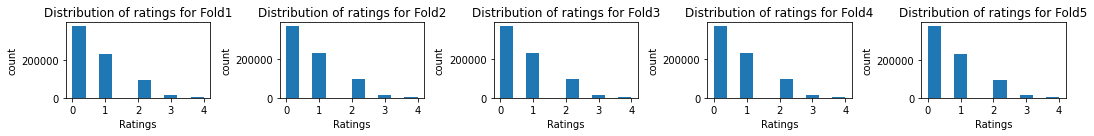

In [4]:
#show the distributions of the labels
def showTraining(data):
    fig, a = plt.subplots(1,5,figsize=(15,2))
    a = a.ravel()
    for idx,ax in enumerate(a):
        ax.hist(data.folds[idx].train['rating'])
        ax.set_title(f'Distribution of ratings for Fold{idx+1}')
        ax.set_xlabel('Ratings')
        ax.set_ylabel('count')
        ax.set_xticks(range(0,5))
    plt.tight_layout()
    
    
    fold_df=pd.DataFrame({f'Fold{idx+1}':fold.train[['rating']].value_counts() for idx,fold in enumerate(data.folds)})
    display(fold_df)
#pd.DataFrame({f'Fold{idx+1}':1.0/(fold.train[['rating']].value_counts()/float(fold.train.shape[0])) for idx,fold in enumerate(data.folds)})
    props=dict(zip(range(5),(data.folds[0].train[['rating']].value_counts()/float(data.folds[0].train.shape[0])).to_list()))
    print('The proportions of each ranking from Fold 1 training data')
    print(props)

showTraining(data)

So it appears that we have an imbalanced dataset with labels that tend towards being irrelevant. There are `~74` times more samples of the irrelevant data than there are of the most relevant data. This is likely due to an implicit feedback mechanism where users did not click the link so it is assumed to be irrelevant. This informs us that we need to either reweight samples so that higher ratings are treated as more important or under(/over) sample some ratings. According to [Seiffert et al.](https://ieeexplore.ieee.org/document/4669722), resampling is more effective than reweighting. There are many choices for resampling and selecting an optimal choice is difficult. Because of time constraints, we will just select undersample the more common classes.

Since I am unable to find a resampling method that includes query id/group information, I will iterate and resample the groups, themselves. I will only resample the training data, not the testing or validation data because I still need to evaluate on the biases inherent to the data.

,Fold1,Fold2,Fold3,Fold4,Fold5
rating,,,,,
2,41634,41163,40996,41225,41658
1,40231,39478,38891,39427,40291
0,33690,33286,33288,33394,34105
3,12088,12173,12369,12242,12298
4,4919,5125,5144,5029,4992


The proportions of each ranking from Fold 1 training data
{0: 0.3140719059760716, 1: 0.30348817911618714, 2: 0.25414523015645507, 3: 0.09118751980205489, 4: 0.0371071649492313}


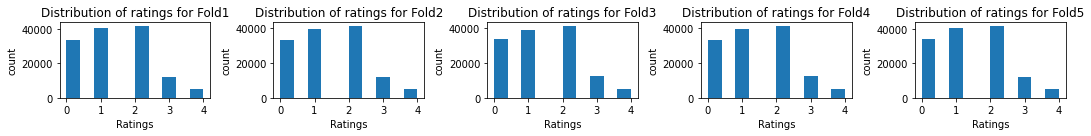

In [5]:
#Downsample the dataset to balance the classes
for fold in data.folds:
    fold.balance()

showTraining(data)
#props=dict(zip(range(5),(balanced[['rating']].value_counts()/float(balanced.shape[0])).to_list()))
#print(props)
#counts=dict(zip(range(5),(balanced[['rating']].value_counts()).to_list()))
#print(counts)

So the data is still somewhat imbalanced, but the imbalance has been reduced to only an `~8x` discrepancy between the least common and most common labels. The next step, time permitting, would be to oversample the relevant ratings (`3` and `4`). Reweighting could also still be used in order to boost howf important the 

It can be hard to decide whether feature selection is part of modeling or preprocessing. In this case we selected to use a boosted decision tree (XGBoost). This choice means that the generated forest will already be performing feature selection so we do not have to. After running, we can verify whether our model finds the same features irrelevant that other approaches find irrelevant.

### 4) Build ranking model

In [6]:
# Build ranking model

model = xgb.XGBRanker(
    #Since I have an AMD GPU, I cannot use 'gpu_hist', this possibly hinders the accuracy of the model
    #tree_method='gpu_hist',
    tree_method='hist',
    booster='gbtree',
    objective='rank:pairwise',
    eta=0.05)



We selected the `XGBRanker` because boosted decision trees (such as lambdaMART) are SOTA on ranking tasks and `XGBoost` is efficient.

We decided to 5-Fold Cross-validation because the data was presented in 5 predefined folds. This selection was because we are expecting other people to use the folds in the same way.

In [7]:
#Set data up for cross-validation
trainMask,trainX,trainY,trainQid,valiX,valiY,valiQid,testX,testY,testQid=data.getCrossvalidationFolds()
ps = PredefinedSplit(trainMask)

We tune our model using randomized grid search over our 5-fold cross-validation. We use only the training set for this. That way when we get results we can have an unbiased estimator of how well we did over the validation set and revise our model if we choose to do so.

In [10]:
#trainX,trainY,qid=data.folds[0].getXYQid('train')
#model.fit(trainX, trainY, qid=qid)

#params to search through for tuning
params = {'n_estimators': stats.randint(50, 100),
          'learning_rate': stats.uniform(0.1, 0.59),
          'subsample': stats.uniform(0.3, 0.6),
          'max_depth': [3, 4, 5, 6, 7],
          'colsample_bytree': stats.uniform(0.5, 0.4),
          'min_child_weight': [0.05, 0.1, 0.15, 0.02]}

clf = RandomizedSearchCV(model,
                         param_distributions=params,
                         cv=ps,
                         n_iter=5,
                         scoring = metrics.make_scorer(metrics.ndcg_score, greater_is_better=True),
                         error_score=0,
                         verbose=3,
                         n_jobs=-1)

search=clf.fit(trainX,trainY,qid=trainQid)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/blueblob/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/blueblob/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/blueblob/.local/lib/python3.8/site-packages/xgboost/core.py", line 506, in inner_f
    return f(**kwargs)
  File "/home/blueblob/.local/lib/python3.8/site-packages/xgboost/sklearn.py", line 1708, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "/home/blueblob/.loca

NotFittedError: All estimators failed to fit

### 5) Evaluate model performance

In [ ]:
# Evaluate model performance

# Discussion

### 6) Please answer the following questions about your choices:
- **Discuss your model and why you chose the model you chose (eg architecture, design, loss functions, etc)**

Learning to Rank (L2R) approaches tend to fall in three categories:
 * Pointwise - Optimize a score for each document and rankings are are in order by score.
 * Pairwise - Given two documents, optimize the margin between them.
 * Listwise - Given two ranked lists, optimize for the better list.

It appears as though most of the state-of-the-art (SOTA) models are currently pairwise. There is not a big enough benefit from moving to listwise approaches and pointwise approaches are just solving regression or classification problems, and not properly penalizing for getting an incorrect ordering.

With the success of neural networks on many problems, it is tempting to select a neural network approach. Unfortunately, the sparseness of typical L2R problems on tabular data makes deep models prone to overfitting, a problem that showed up for [Burges et al.](https://proceedings.mlr.press/v14/burges11a/burges11a.pdf) in LambdaRANK. This is not to say that all deep models will have this problem.The features in this dataset are not well comparable between each other if they were embedded in the same space. As an example, the TF and IDF values are computed with respect to the query and interactions between the terms are lost. Comparing TF and IDF values across different rows doesn't make much sense because they are computed with respect to the query. Had word vectors been used instead, there would be more benefit to using a deep model.

I elected to use `XGRanker` from `XGBoost` which is a SOTA framework for boosted decision trees that is highly efficient. LambdaMART is a state of the art approach using bagged, boosted decision trees as well. So my approach is similar to a SOTA approach. Trading off the amount of time to train gives me a little more time to tune hyperparameters.

- **Why did you choose your metric to evaluate the model?**

Normalized Discounted Cumulative Gain (NDCG) and Mean Average Precision (MAP) are the selected metrics by the authors of the dataset. This implies that most people using the dataset will provide results for these metrics. In order to be able to compare with other approaches, we should **at least** use the same comparison metrics. These metrics also show up in many other papers such as [Burges et al.](https://proceedings.mlr.press/v14/burges11a/burges11a.pdf). Burges found that there was little to no difference between NDCG and Expected Reciprocal Rank.

- **How well would you say your model performed?**
- **If you had more time what else would you want to try?**

Given time restrictions and trying to keep everything in the notebook format, I have not worked on memory management for the dataset. Streaming the data so it does not all have to be loaded simultaneously would be beneficial.

Spending more time parameter tuning could yield a better model.

Comparing other approaches and how well they perform would give a much more insightful picture.

With this particular dataset, there really is not that much more I would like to try. Problematically, this dataset contains mostly summary statistics and removes the actual raw data. I would not blame the authors for this because there are potential privacy concerns. I do, however, believe that it limits the scope of usefulness of the data. Since my time is finite, I would rather spend my time on a dataset that includes the actual textual data.

### 7) Please answer the following questions about how you would use additional features:

- **If you had an additional feature for each row of the dataset that was unique identifier for the user performing the query e.g. `user_id`, how could you use it to improve the performance of the model?**

An additional row for the user translates this from a L2R problem to a User Modeling or Recommender Systems problem instead of an Information Retrieval problem. The reality is that users do not all rank things the same because they have different preferences, decision making styles, and different reasons for searching (tasks). The general idea behind user modeling is that users that rank things similarly have some of the aforementioned properties in common. Leveraging those properties enables one to make recommendations that are better suited to each individual in a technique called Collaborative Filtering (CF).

A great approach to to solve this problem would be Weighted Matrix Factorization (WMF). Solving a WMF problem with Stochastic Gradient Descent (SGD) would likely yield pretty good results. This dataset would still suffer, however, because the features themselves are not selected to perform well. As I described in Section 6, bullet 1, the interactions between the features are not as useful as the raw data would be.

- **If you had the additional features of: `query_text` or the actual textual query itself, as well as document text features like `title_text`, `body_text`, `anchor_text`, `url` for the document, how would you include them in your model (or any model) to improve its performance?**

It is not clear to me whether this is also using the `user_id` from the previous bullet. If it is using `user_id` then I would recast the problem as one of Matrix Completion. The idea is that the number of rankings from each individual is typically very small compared to the number items to rank. So mapping items and user preferences to an embedding space where relationships between them can be explored enables one to generate ratings for unseen content. In this embedding space we can predict intermediate values. Then we can use Collaborative Filtering to I would be interested in solving Matrix Completion with a Transformer and then using Stochastic Gradient Descent to solve WMF. The beauty of this approach is that we can give completed items in the matrix lower weights and tune to boost performance by leveraging intermediate values.

If we are leaving `user_id` out and just using the text, then we have a classic content-based filtering in the Recommender Systems world. We might use a Transformer with `Q=query_text`, `K=title_text`, and `V=body_text`. Then the output from the Encoder would be a potential feature representation space that could be features concatenated with the classical features we already have. Then we could solve the same Learning to Rank problem over the new features with the same approach we used in this document.

### 8) Please submit your colab by sharing it with: cmaon@oreilly.com and rlandry@oreilly.com
